In [ ]:
#@title Carga de Informacion
import pandas as pd
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  df = pd.read_excel(fn)
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving presidencial_2025.xlsx to presidencial_2025.xlsx
Saving presidenciales_2005_2021.xlsx to presidenciales_2005_2021.xlsx
User uploaded file "presidencial_2025.xlsx" with length 25269 bytes
User uploaded file "presidenciales_2005_2021.xlsx" with length 59687 bytes


In [ ]:
df = pd.read_excel('presidenciales_2005_2021.xlsx')
df.head()

,Candidato,Nro.Voto,Nombre,Apellido,Partido,Votos,% Votos Presidencial 2021,Año Presidencial,c1,c10,...,c90,c91,c92,c93,c94,c95,c96,c97,c98,c99
0,1_2021,1,GABRIEL,BORIC,CS,4596579,0.551825,2021,4384,0,...,1731,2460,228,0,40565,0,0,2085,583,4538
1,2_2021,2,JOSE ANTONIO,KAST,PRCh,3640606,0.437059,2021,4915,870,...,6069,4513,2816,3587,6951,4279,8335,981,5042,3281
2,VN_2021,VN,VN,VN,NaN,68616,0.008237,2021,73,7,...,58,95,10,39,559,81,113,65,54,52
3,VB_2021,VB,VB,VB,NaN,23972,0.002878,2021,90,4,...,51,39,24,39,421,83,123,32,73,87
4,1_2017,3,SEBASTIAN,PIÑERA,IND,3796918,0.539881,2017,7574,424,...,2501,2130,2765,3317,19344,1638,4898,1393,3290,5059


In [ ]:
df_2024 = pd.read_excel('presidencial_2025.xlsx')
df_2024.head()

,Candidato,Nro.Voto,Nombre,Apellido,Partido,Votos,% Votos Presidencial 2021,Año Presidencial,c1,c10,...,c90,c91,c92,c93,c94,c95,c96,c97,c98,c99
0,1_2024,NaN,Derecha,Derecha,Derecha,NaN,NaN,2025,9295,233,...,1860,0,0,747,19072,1151,4293,954,1875,7816
1,2_2024,NaN,Izquierda,Izquierda,Izquierda,NaN,NaN,2025,6336,999,...,12252,13254,4047,5721,64718,8438,13991,4247,8194,8194
2,VB_2024,VB,Voto Blanco,Voto Blanco,Voto Blanco,NaN,NaN,2025,623,17,...,366,392,32,120,5120,299,815,133,407,480
3,VN_2024,VN,Voto Nulo,Voto Nulo,Voto Nulo,NaN,NaN,2025,822,22,...,895,1092,40,160,9105,442,1302,156,436,741


In [ ]:
# @title Función que construye la data X e Y
def build_data(df):
    #df = pd.read_excel('presidenciales_2005_2021.xlsx')

    # borrar filas con valor VN y VB en columna Nro.Voto
    df = df[df['Nro.Voto'] != 'VN']
    df = df[df['Nro.Voto'] != 'VB']

    # Filtrar las columnas que comienzan con "c"
    columnas_c = [col for col in df.columns if col.startswith('c')]

    # Agrupar por "Año Presidencial" y convertir a porcentajes en decimales
    df[columnas_c] = df.groupby('Año Presidencial')[columnas_c].transform(lambda x: x / x.sum())

    df.rename(columns={"% Votos Presidencial 2021": "%_votos", "Año Presidencial": "año"}, inplace=True)

    X_cols = [col for col in df.columns if col.startswith('c')]
    Y_cols = ['%_votos']

    X = df[X_cols].values
    Y = df[Y_cols].values.reshape(-1, 1)

    print(X.shape)
    print(Y.shape)
    return X, Y

In [ ]:
X, Y = build_data(df)

(10, 345)
(10, 1)


In [ ]:
# @title Funcion que modifica datos nuevos
def build_data_test(df):
    df_test = df.copy()

    # borrar filas con valor VN y VB en columna Nro.Voto
    df_test = df_test[df_test['Nro.Voto'] != 'VN']
    df_test = df_test[df_test['Nro.Voto'] != 'VB']

    # Filtrar las columnas que comienzan con "c"
    columnas_c = [col for col in df_test.columns if col.startswith('c')]

    # Agrupar por "Año Presidencial" y convertir a porcentajes en decimales
    df_test[columnas_c] = df_test.groupby('Año Presidencial')[columnas_c].transform(lambda x: x / x.sum())

    df_test.rename(columns={"% Votos Presidencial 2021": "%_votos", "Año Presidencial": "año"}, inplace=True)

    X_cols = [col for col in df.columns if col.startswith('c')]
    Y_cols = ['%_votos']

    X_pred = df_test[X_cols].values
    Y_pred = df_test[Y_cols].values.reshape(-1, 1)
    print(X_pred.shape)
    print(Y_pred.shape)
    return X_pred, Y_pred

In [ ]:
X_2024, Y_2024 = build_data_test(df_2024)

(2, 345)
(2, 1)


# PLS

In [ ]:
# @title función que corre PLS (Profesor)
def correr_PLS(X, Y, n, k, test_size=0.2):
    # n : número de veces
    # k : número de componentes latentes
    # test_size : tamaño del conjunto de prueba
    from sklearn.model_selection import train_test_split
    from sklearn.cross_decomposition import PLSRegression
    from sklearn.metrics import mean_squared_log_error
    from sklearn.metrics import mean_squared_error
    mse_list = []
    for i in range(n):
        # Dividir los datos en conjunto de entrenamiento y prueba
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=i)

        # Crear un modelo PLS con 2 componentes latentes
        pls = PLSRegression(n_components=k)

        # Ajustar el modelo con el conjunto de entrenamiento
        pls.fit(X_train, Y_train)

        # Hacer predicciones
        Y_pred = pls.predict(X_test)

        # Evaluar el modelo
        mse = mean_squared_error(Y_test, Y_pred)
        print(f"Mean Squared Error: {mse:.4f}")
        mse_list.append(mse)

        # Ver los pesos de las variables predictoras
        print("Pesos de las variables predictoras (X_weights):")
        print(pls.x_weights_)

        # Ver los pesos de las variables respuesta
        print("Pesos de las variables respuesta (Y_weights):")
        print(pls.y_weights_)
    # mse promedio
    mse_promedio = sum(mse_list) / n
    print(f"Mean Squared Error promedio: {mse_promedio:.4f}")
    return mse_promedio


In [ ]:
mse = correr_PLS(X, Y, 10, 2)

Mean Squared Error: 0.0008
Pesos de las variables predictoras (X_weights):
[[ 0.02475013  0.06617021]
 [ 0.01507643  0.04459929]
 [-0.00104121  0.07420298]
 [ 0.10029561  0.07098825]
 [ 0.01454965  0.07912433]
 [-0.09195317  0.027695  ]
 [-0.05069335  0.05533922]
 [ 0.03869969  0.052361  ]
 [-0.07050235  0.00703877]
 [-0.07026374  0.05678862]
 [-0.02328641  0.02273231]
 [-0.05101531  0.05973428]
 [ 0.03995901  0.05498352]
 [-0.0099615   0.02423244]
 [ 0.02464068  0.04290928]
 [ 0.00714431  0.07372578]
 [ 0.03421996  0.05540589]
 [ 0.04184418 -0.06233892]
 [ 0.04080686  0.077173  ]
 [-0.0390734   0.04706569]
 [-0.04300889 -0.01776371]
 [-0.01641307  0.00387117]
 [ 0.00827142  0.06394781]
 [ 0.01643972  0.08654169]
 [-0.0644404  -0.07734072]
 [ 0.01674434  0.01239957]
 [-0.03962112  0.06189566]
 [-0.04342345  0.07521885]
 [-0.02048237  0.08499667]
 [ 0.04320612 -0.01609499]
 [-0.06926521 -0.02476891]
 [-0.03445519  0.03512351]
 [-0.01239016  0.05326857]
 [-0.05580202  0.05513913]
 [-0.07

In [ ]:
# @title Funcion PLS_2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error

def correr_PLS_2(X, Y, n, max_k, test_size=0.2):
    """
    Corre múltiples modelos PLS para diferentes números de componentes latentes y devuelve los resultados.

    Args:
        X (array-like): Matriz de predictores.
        Y (array-like): Variable objetivo.
        n (int): Número de iteraciones (train-test splits).
        max_k (int): Número máximo de componentes latentes a probar.
        test_size (float): Tamaño del conjunto de prueba.

    Returns:
        DataFrame: Contiene los resultados del MSE promedio para cada k y una recomendación del mejor k.
    """
    resultados = []

    for k in range(1, max_k + 1):  # Probar con 1 hasta max_k componentes latentes
        mse_list = []

        for i in range(n):
            # Dividir los datos en entrenamiento y prueba
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=i)

            # Crear y ajustar el modelo PLS
            pls = PLSRegression(n_components=k)
            pls.fit(X_train, Y_train)

            # Hacer predicciones
            Y_pred = pls.predict(X_test)

            # Calcular el error cuadrático medio
            mse = mean_squared_error(Y_test, Y_pred)
            mse_list.append(mse)

        # Calcular el MSE promedio para este número de componentes
        mse_promedio = sum(mse_list) / n
        resultados.append({'Componentes': k, 'MSE_promedio': mse_promedio})

    # Convertir los resultados a un DataFrame
    resultados_df = pd.DataFrame(resultados)

    # Encontrar el número óptimo de componentes (con el menor MSE promedio)
    mejor_k = resultados_df.loc[resultados_df['MSE_promedio'].idxmin(), 'Componentes']
    print(f"El número óptimo de componentes latentes es: {mejor_k}")

    return resultados_df, mejor_k


El número óptimo de componentes latentes es: 4
   Componentes  MSE_promedio
0            1  4.067349e-03
1            2  1.876640e-03
2            3  1.072333e-03
3            4  9.783503e-04
4            5  1.131316e+24
5            6  1.475150e+24
6            7  1.417931e+24
7            8  1.303448e+24


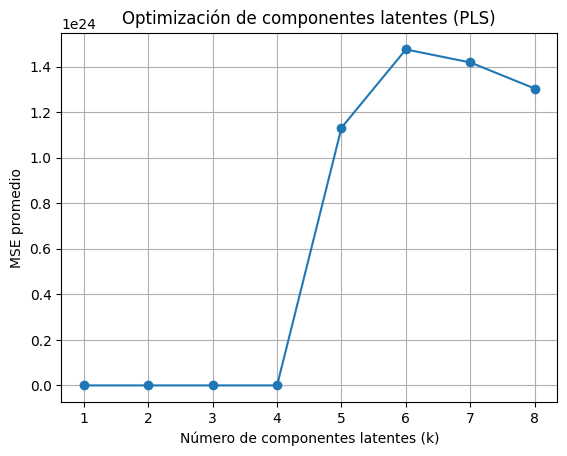

In [ ]:
# X e Y deben ser tus datos (pueden ser arrays o DataFrames)
resultados_df_pls, mejor_k_pls = correr_PLS_2(X, Y, n=1000, max_k=8, test_size=0.2)

# Mostrar los resultados
print(resultados_df_pls)

# Graficar los resultados para visualizar el comportamiento
import matplotlib.pyplot as plt

plt.plot(resultados_df_pls['Componentes'], resultados_df_pls['MSE_promedio'], marker='o')
plt.xlabel('Número de componentes latentes (k)')
plt.ylabel('MSE promedio')
plt.title('Optimización de componentes latentes (PLS)')
plt.grid()
plt.show()


In [ ]:
# @title Aplicacion PLS para prediccion.
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error

# Crear un modelo PLS con 2 componentes latentes
modelo_pls = PLSRegression(n_components=mejor_k_pls)

# Ajustar el modelo con el conjunto de entrenamiento
modelo_pls.fit(X, Y)

# Realizamos prediccion
Y_pred_pls = modelo_pls.predict(X_2024)

# Mostramos las predicciones
print("Predicciones realizadas:")
print(Y_pred_pls)


Predicciones realizadas:
[[0.47591422]
 [0.50321455]]


In [ ]:
# @title Funcion PLS con pesos
def correr_PLS_con_pesos(X, Y, k, X_cols=None):
    """
    Ajusta un modelo PLS con k componentes latentes y devuelve los pesos de las variables predictoras.

    Args:
        X (array-like): Matriz de predictores (comunas).
        Y (array-like): Variable objetivo.
        k (int): Número de componentes latentes.
        X_cols (list): Lista con los nombres de las columnas (opcional).

    Returns:
        DataFrame: Contiene los pesos de las comunas para cada componente latente.
    """
    from sklearn.cross_decomposition import PLSRegression
    import pandas as pd

    # Si no se proporcionan nombres, generar genéricos
    if X_cols is None:
        X_cols = [f"Var{i+1}" for i in range(X.shape[1])]

    # Ajustar el modelo PLS con k componentes
    pls = PLSRegression(n_components=k)
    pls.fit(X, Y)

    # Extraer los pesos de las variables predictoras
    pesos = pls.x_weights_  # Pesos de las comunas en cada componente

    # Crear un DataFrame para facilitar la interpretación
    pesos_df = pd.DataFrame(
        pesos,
        index=X_cols,  # Usar los nombres proporcionados como índice
        columns=[f'Componente_{i+1}' for i in range(k)]  # Nombrar las componentes
    )

    # Mostrar los pesos
    print("Pesos de las variables predictoras (comunas):")
    print(pesos_df)

    return pesos_df


In [ ]:
# Extraer las columnas de las comunas
X_cols = [col for col in df.columns if col.startswith('c')]

# Seleccionar las columnas de las comunas como matriz de predictores
X_2 = df[X_cols]

# Supongamos que Y es tu variable objetivo
Y_2 = df['% Votos Presidencial 2021']  # Cambia 'votos' por el nombre de tu columna objetivo

# Llamar a la función con los nombres de las comunas
pesos_comunas = correr_PLS_con_pesos(X_2.values, Y_2.values, k=4, X_cols=X_cols)

# Iterar sobre cada componente latente
for componente in pesos_comunas.columns:
    print(f"Comunas más importantes en {componente}:")

    # Ordenar las comunas por su peso en el componente actual
    comunas_importantes = pesos_comunas[componente].sort_values(ascending=False)

    # Mostrar las 10 comunas más importantes para este componente
    print(comunas_importantes.head(10))
    print("\n")


Pesos de las variables predictoras (comunas):
      Componente_1  Componente_2  Componente_3  Componente_4
c1        0.056120      0.023240     -0.015879      0.039594
c10       0.046068     -0.066050      0.042762     -0.080195
c100      0.048094     -0.055865     -0.062218     -0.066887
c101      0.067410      0.085365     -0.045546     -0.005479
c102      0.054617     -0.014595     -0.037288     -0.033300
...            ...           ...           ...           ...
c95       0.049294     -0.033116      0.072461     -0.026267
c96       0.051377     -0.058496      0.055193      0.020466
c97       0.065117      0.108568      0.012437     -0.034410
c98       0.058022     -0.012836     -0.002419      0.028846
c99       0.064589      0.069807     -0.005453     -0.071331

[345 rows x 4 columns]
Comunas más importantes en Componente_1:
c101    0.067410
c81     0.067271
c264    0.066830
c219    0.066782
c250    0.066226
c322    0.065978
c53     0.065865
c267    0.065613
c131    0.065402
c89 

In [ ]:
# @title Funcion Calculo de Varianza Explicada
from sklearn.cross_decomposition import PLSRegression
import numpy as np

def calcular_varianza_explicada(X, Y, k):
    # Crear y ajustar el modelo PLS
    pls = PLSRegression(n_components=k)
    pls.fit(X, Y)

    # Calcular la varianza explicada manualmente
    # Varianza explicada por componente es la varianza de las proyecciones dividida por la varianza total
    varianza_X = np.var(pls.x_scores_, axis=0)
    varianza_explicada = varianza_X / np.sum(varianza_X)

    return varianza_explicada


In [ ]:
#@title Llamada Calculo Varianza Explicada

# Calcular la varianza explicada para k componentes
varianza_explicada = calcular_varianza_explicada(X_2.values, Y_2.values, k=4)

# Imprimir la varianza explicada por componente
print("Varianza explicada por cada componente:")
for i, var in enumerate(varianza_explicada):
    print(f"Componente {i+1}: {var:.2%}")


Varianza explicada por cada componente:
Componente 1: 86.73%
Componente 2: 6.66%
Componente 3: 3.60%
Componente 4: 3.02%


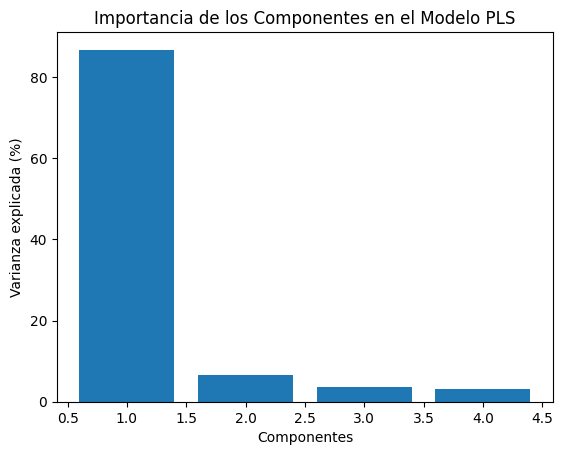

In [ ]:
#@title Vizualizacion Varianza Explicada
import matplotlib.pyplot as plt

plt.bar(range(1, len(varianza_explicada) + 1), varianza_explicada * 100)
plt.xlabel('Componentes')
plt.ylabel('Varianza explicada (%)')
plt.title('Importancia de los Componentes en el Modelo PLS')
plt.show()


# PCR

In [ ]:
# @title buscar_componentes_optimos_PCR
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas as pd

def buscar_componentes_optimos_PCR(X, Y, max_k, test_size=0.2):
    """
    Busca el número óptimo de componentes principales para PCR.

    Args:
        X (array-like): Matriz de predictores (comunas).
        Y (array-like): Variable objetivo.
        max_k (int): Número máximo de componentes principales a probar.
        test_size (float): Tamaño del conjunto de prueba.

    Returns:
        DataFrame: Contiene el MSE promedio para cada número de componentes principales.
        int: Número óptimo de componentes principales.
    """
    mse_list = []

    # Dividir los datos en conjunto de entrenamiento y prueba
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)

    for k in range(1, max_k + 1):
        # Realizar PCA con k componentes principales
        pca = PCA(n_components=k)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        # Ajustar un modelo de regresión lineal en el espacio reducido
        modelo = LinearRegression()
        modelo.fit(X_train_pca, Y_train)

        # Predecir en el conjunto de prueba
        Y_pred = modelo.predict(X_test_pca)

        # Calcular el error cuadrático medio
        mse = mean_squared_error(Y_test, Y_pred)
        mse_list.append({'Componentes': k, 'MSE': mse})

    # Convertir los resultados a un DataFrame
    resultados = pd.DataFrame(mse_list)

    # Encontrar el número de componentes con el menor MSE
    mejor_k = resultados.loc[resultados['MSE'].idxmin(), 'Componentes']
    print(f"El número óptimo de componentes principales es: {mejor_k}")

    return resultados, mejor_k


El número óptimo de componentes principales es: 5
   Componentes       MSE
0            1  0.005054
1            2  0.004380
2            3  0.001090
3            4  0.000190
4            5  0.000078
5            6  0.000078
6            7  0.000078
7            8  0.000078


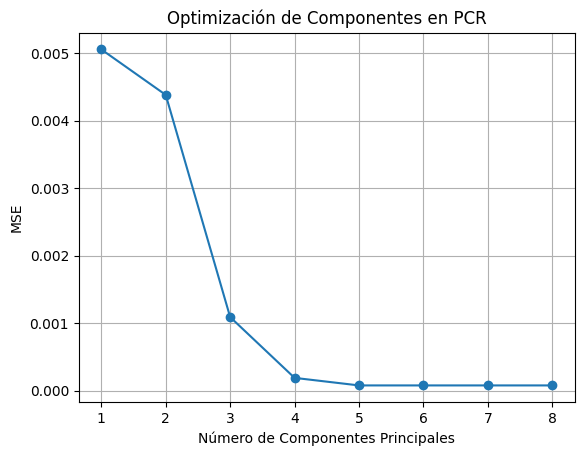

In [ ]:
# Buscar el número óptimo de componentes principales
resultados_pcr, mejor_k_pcr = buscar_componentes_optimos_PCR(X, Y, max_k=8, test_size=0.2)

# Mostrar los resultados
print(resultados_pcr)

# Graficar el MSE en función del número de componentes principales
import matplotlib.pyplot as plt

plt.plot(resultados_pcr['Componentes'], resultados_pcr['MSE'], marker='o')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('MSE')
plt.title('Optimización de Componentes en PCR')
plt.grid()
plt.show()


In [ ]:
# @title correr_PCR_con_pesos
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

def correr_PCR_con_pesos(X, Y, k):
    """
    Ajusta un modelo PCR con k componentes principales y devuelve los pesos de las variables predictoras.

    Args:
        X (array-like): Matriz de predictores (comunas).
        Y (array-like): Variable objetivo.
        k (int): Número de componentes principales.

    Returns:
        DataFrame: Contiene los pesos de las comunas para cada componente principal.
    """
    import pandas as pd

    # Realizar PCA con k componentes
    pca = PCA(n_components=k)
    X_pca = pca.fit_transform(X)  # Transformar X al espacio de componentes principales

    # Ajustar un modelo de regresión lineal en el espacio de componentes principales
    modelo = LinearRegression()
    modelo.fit(X_pca, Y)

    # Extraer los pesos (cargas) de las comunas en cada componente principal
    pesos = pca.components_.T  # Transponer para obtener cada variable como filas

    # Crear un DataFrame para facilitar la interpretación
    pesos_df = pd.DataFrame(
        pesos,
        index=X.columns,  # Usar los nombres de las comunas como índice
        columns=[f'Componente_{i+1}' for i in range(k)]  # Nombrar los componentes principales
    )

    # Mostrar los pesos
    print("Pesos de las variables predictoras (comunas):")
    print(pesos_df)

    return pesos_df


In [ ]:
# Extraer las columnas de las comunas
X_cols = [col for col in df.columns if col.startswith('c')]

# Seleccionar las columnas de las comunas como matriz de predictores
X_3 = df[X_cols]

# Supongamos que Y es tu variable objetivo
Y_3 = df['% Votos Presidencial 2021']  # Cambia 'votos' por el nombre de tu columna objetivo

# Llamar a la función con el número de componentes principales
pesos_comunas_pcr = correr_PCR_con_pesos(X_3, Y_3, k=mejor_k_pcr)

# Identificar las comunas más importantes para cada componente
for componente in pesos_comunas_pcr.columns:
    print(f"Comunas más importantes en {componente}:")
    comunas_importantes = pesos_comunas_pcr[componente].sort_values(ascending=False)
    display(comunas_importantes.head(10))
    print("\n")


Pesos de las variables predictoras (comunas):
      Componente_1  Componente_2  Componente_3  Componente_4  Componente_5
c1        0.017259      0.002265      0.008864      0.035525      0.023169
c10       0.001765     -0.000250     -0.003707     -0.001175      0.001372
c100      0.003299      0.002531     -0.004489      0.003639     -0.002580
c101      0.011068     -0.006721      0.009066     -0.000032      0.004422
c102      0.012883      0.002806     -0.008380      0.021955     -0.006698
...            ...           ...           ...           ...           ...
c95       0.010648     -0.005430     -0.015038     -0.016578      0.026840
c96       0.019621      0.005146     -0.021180     -0.011222      0.019553
c97       0.005000     -0.008458      0.003948      0.000526      0.005285
c98       0.013161      0.004106     -0.003274     -0.013452      0.007071
c99       0.013216     -0.016373     -0.000103      0.013317      0.002319

[345 rows x 5 columns]
Comunas más importantes en Com

,Componente_1
c168,0.268456
c124,0.248383
c338,0.237352
c139,0.229347
c238,0.217125
c346,0.199804
c11,0.176790
c313,0.173352
c66,0.161689
c192,0.156556




Comunas más importantes en Componente_2:


,Componente_2
c139,0.428273
c234,0.328442
c338,0.266071
c347,0.206730
c149,0.139451
c66,0.124962
c129,0.111399
c270,0.095107
c62,0.094259
c40,0.092085




Comunas más importantes en Componente_3:


,Componente_3
c346,0.440031
c238,0.323646
c192,0.205804
c139,0.172057
c158,0.169702
c47,0.169657
c117,0.158077
c313,0.135510
c265,0.114593
c336,0.109094




Comunas más importantes en Componente_4:


,Componente_4
c11,0.334058
c168,0.323097
c117,0.263715
c238,0.177161
c71,0.156066
c265,0.116188
c198,0.115086
c244,0.103983
c291,0.103662
c255,0.098354




Comunas más importantes en Componente_5:


,Componente_5
c11,0.377844
c158,0.333185
c198,0.199662
c14,0.172387
c197,0.158804
c66,0.143925
c192,0.139900
c270,0.138213
c139,0.127399
c268,0.107550


In [ ]:
# @title Funcion Calculo Varianza PCR
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import numpy as np

def calcular_varianza_explicada_PCR(X, Y, k):
    # Crear y ajustar el modelo PCA
    pca = PCA(n_components=k)
    X_reducido = pca.fit_transform(X)

    # Calcular la varianza explicada por los componentes principales
    varianza_explicada = pca.explained_variance_ratio_

    # Ajustar un modelo de regresión lineal con los componentes principales
    modelo_regresion = LinearRegression()
    modelo_regresion.fit(X_reducido, Y)

    return varianza_explicada, pca


In [ ]:
#@title Calcular la varianza explicada usando PCR
varianza_explicada_PCR, modelo_pca = calcular_varianza_explicada_PCR(X_3.values, Y_3.values, k=mejor_k_pcr)

# Imprimir los resultados
print("Varianza explicada por componente (PCR):")
for i, var in enumerate(varianza_explicada_PCR):
    print(f"Componente {i+1}: {var:.2%}")


Varianza explicada por componente (PCR):
Componente 1: 77.64%
Componente 2: 7.73%
Componente 3: 6.73%
Componente 4: 3.08%
Componente 5: 2.07%


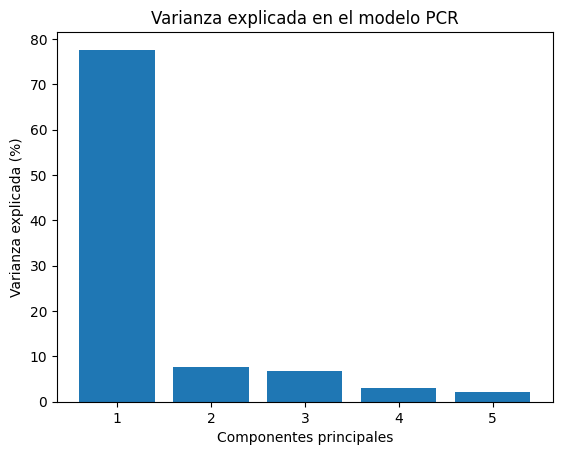

In [ ]:
# @title Vizualizacion Varianza Explicada PCR
import matplotlib.pyplot as plt

plt.bar(range(1, len(varianza_explicada_PCR) + 1), varianza_explicada_PCR * 100)
plt.xlabel('Componentes principales')
plt.ylabel('Varianza explicada (%)')
plt.title('Varianza explicada en el modelo PCR')
plt.show()


In [ ]:
# @title Aplicacion PCR para predicion
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

# Crear el modelo PCA con el mejor número de componentes
pca = PCA(n_components=mejor_k_pcr)

# Ajustar el modelo PCA al conjunto de entrenamiento
X_reducido = pca.fit_transform(X)

# Crear un modelo de regresión lineal sobre los componentes principales
modelo_pcr = LinearRegression()

# Ajustar el modelo de regresión
modelo_pcr.fit(X_reducido, Y)

# Transformar el conjunto de predicción con el mismo PCA
X_2024_reducido = pca.transform(X_2024)

# Realizar las predicciones con el modelo de regresión
Y_pred_pcr = modelo_pcr.predict(X_2024_reducido)

# Mostrar las predicciones
print("Predicciones realizadas con PCR:")
print(Y_pred_pcr)


Predicciones realizadas con PCR:
[[0.48265261]
 [0.49647616]]


# Eliminando 1 presidente x Eleccion

In [ ]:
df_elim = df.copy()

# Filtrar para eliminar votos nulos y blancos
df_elim = df_elim[~df_elim['Candidato'].str.startswith(('VN', 'VB'))]

# Obtener el candidato con más votos en cada año
df_elim = df_elim.loc[df_elim.groupby('Año Presidencial')['Votos'].idxmax()]

# Mostrar el DataFrame final
df_elim


,Candidato,Nro.Voto,Nombre,Apellido,Partido,Votos,% Votos Presidencial 2021,Año Presidencial,c1,c10,...,c90,c91,c92,c93,c94,c95,c96,c97,c98,c99
17,2_2005,C2,MICHELLE,BACHELET,PS,3723019,0.519804,2005,1718,497,...,3436,2186,1087,1784,34230,2363,4750,1311,3430,3585
12,1_2009,C3,SEBASTIAN,PIÑERA,RN,3591182,0.498542,2009,4005,87,...,1247,842,1270,1246,21404,1156,2915,1158,3187,2018
8,1_2013,6,MICHELLE,BACHELET,PS,3470379,0.609079,2013,5206,397,...,3265,4072,240,2518,23497,3511,4528,1695,3317,4326
4,1_2017,3,SEBASTIAN,PIÑERA,IND,3796918,0.539881,2017,7574,424,...,2501,2130,2765,3317,19344,1638,4898,1393,3290,5059
0,1_2021,1,GABRIEL,BORIC,CS,4596579,0.551825,2021,4384,0,...,1731,2460,228,0,40565,0,0,2085,583,4538


In [ ]:
# nan como 0
df_elim = df_elim.fillna(0)


In [ ]:
X_elim, Y_elim = build_data(df_elim)

(5, 345)
(5, 1)


In [ ]:
X_elim = np.nan_to_num(X_elim, nan=0.0)


In [ ]:
resultados_df_elim_pls, df_elim_mejor_k_pls = correr_PLS_2(X_elim, Y_elim, n=1000, max_k=3, test_size=0.4)

/usr/local/lib/python3.11/dist-packages/sklearn/cross_decomposition/_pls.py:348: UserWarning: y residual is constant at iteration 2
  warnings.warn(f"y residual is constant at iteration {k}")
/usr/local/lib/python3.11/dist-packages/sklearn/cross_decomposition/_pls.py:348: UserWarning: y residual is constant at iteration 2
  warnings.warn(f"y residual is constant at iteration {k}")
/usr/local/lib/python3.11/dist-packages/sklearn/cross_decomposition/_pls.py:348: UserWarning: y residual is constant at iteration 2
  warnings.warn(f"y residual is constant at iteration {k}")
/usr/local/lib/python3.11/dist-packages/sklearn/cross_decomposition/_pls.py:348: UserWarning: y residual is constant at iteration 2
  warnings.warn(f"y residual is constant at iteration {k}")
/usr/local/lib/python3.11/dist-packages/sklearn/cross_decomposition/_pls.py:348: UserWarning: y residual is constant at iteration 2
  warnings.warn(f"y residual is constant at iteration {k}")
/usr/local/lib/python3.11/dist-packages/

El número óptimo de componentes latentes es: 2


/usr/local/lib/python3.11/dist-packages/sklearn/cross_decomposition/_pls.py:348: UserWarning: y residual is constant at iteration 2
  warnings.warn(f"y residual is constant at iteration {k}")
/usr/local/lib/python3.11/dist-packages/sklearn/cross_decomposition/_pls.py:348: UserWarning: y residual is constant at iteration 2
  warnings.warn(f"y residual is constant at iteration {k}")
/usr/local/lib/python3.11/dist-packages/sklearn/cross_decomposition/_pls.py:348: UserWarning: y residual is constant at iteration 2
  warnings.warn(f"y residual is constant at iteration {k}")
/usr/local/lib/python3.11/dist-packages/sklearn/cross_decomposition/_pls.py:348: UserWarning: y residual is constant at iteration 2
  warnings.warn(f"y residual is constant at iteration {k}")
/usr/local/lib/python3.11/dist-packages/sklearn/cross_decomposition/_pls.py:348: UserWarning: y residual is constant at iteration 2
  warnings.warn(f"y residual is constant at iteration {k}")
/usr/local/lib/python3.11/dist-packages/

   Componentes  MSE_promedio
0            1      0.002591
1            2      0.002020
2            3      0.021707
numero de componentes latentes optimo:2


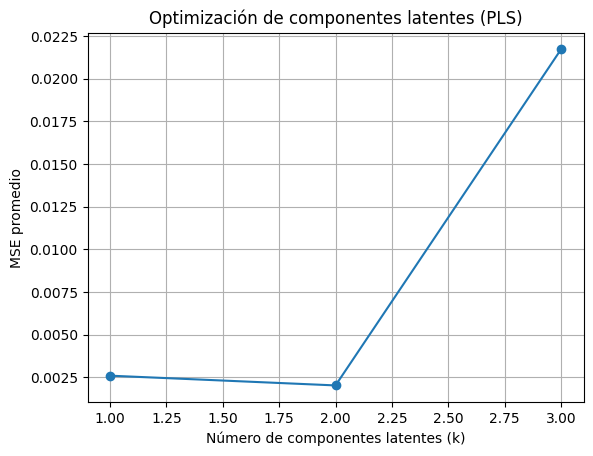

In [ ]:
# Mostrar los resultados
print(resultados_df_elim_pls)

# Graficar los resultados para visualizar el comportamiento
import matplotlib.pyplot as plt
print(f"numero de componentes latentes optimo:{df_elim_mejor_k_pls}")
plt.plot(resultados_df_elim_pls['Componentes'], resultados_df_elim_pls['MSE_promedio'], marker='o')
plt.xlabel('Número de componentes latentes (k)')
plt.ylabel('MSE promedio')
plt.title('Optimización de componentes latentes (PLS)')
plt.grid()
plt.show()

In [ ]:
# Crear un modelo PLS con 2 componentes latentes
modelo_pls_elim = PLSRegression(n_components=df_elim_mejor_k_pls)

# Ajustar el modelo con el conjunto de entrenamiento
modelo_pls_elim.fit(X_elim, Y_elim)

# Realizamos prediccion
Y_pred_pls_elim = modelo_pls_elim.predict(X_2024)

# Mostramos las predicciones
print("Predicciones realizadas:")
print(Y_pred_pls)

Predicciones realizadas:
[[0.47591422]
 [0.50321455]]


El número óptimo de componentes principales es: 1
   Componentes       MSE
0            1  0.001011
1            2  0.001126
2            3  0.001126


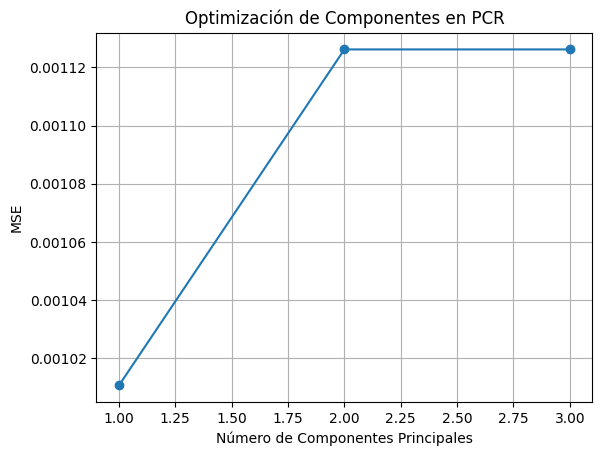

In [ ]:
# Buscar el número óptimo de componentes principales
resultados_pcr_elim, mejor_k_pcr_elim = buscar_componentes_optimos_PCR(X_elim, Y_elim, max_k=3, test_size=0.4)

# Mostrar los resultados
print(resultados_pcr_elim)

# Graficar el MSE en función del número de componentes principales
import matplotlib.pyplot as plt

plt.plot(resultados_pcr_elim['Componentes'], resultados_pcr_elim['MSE'], marker='o')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('MSE')
plt.title('Optimización de Componentes en PCR')
plt.grid()
plt.show()


In [ ]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

# Crear el modelo PCA con el mejor número de componentes
pca_elim = PCA(n_components=mejor_k_pcr_elim)

# Ajustar el modelo PCA al conjunto de entrenamiento
X_reducido_elim = pca.fit_transform(X_elim)

# Crear un modelo de regresión lineal sobre los componentes principales
modelo_pcr_elim = LinearRegression()

# Ajustar el modelo de regresión
modelo_pcr_elim.fit(X_reducido_elim, Y_elim)

# Transformar el conjunto de predicción con el mismo PCA
X_2024_reducido_elim = pca.transform(X_2024)

# Realizar las predicciones con el modelo de regresión
Y_pred_pcr_elim = modelo_pcr_elim.predict(X_2024_reducido_elim)

# Mostrar las predicciones
print("Predicciones realizadas con PCR:")
print(Y_pred_pcr)

Predicciones realizadas con PCR:
[[0.48265261]
 [0.49647616]]


# Betas 0

In [ ]:
# Instalar Pyomo si no lo tienes instalado
!pip install pyomo

# Instalar las dependencias para el solver IPOPT
!apt-get install -y coinor-libipopt-dev

# Descargar e instalar el ejecutable del solver IPOPT
!apt-get install -y coinor-ipopt

# Verificar que IPOPT esté correctamente instalado
!which ipopt


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
coinor-libipopt-dev is already the newest version (3.11.9-2.2build5).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package coinor-ipopt
/usr/local/lib/python3.11/dist-packages/ampl_module_coin/bin/ipopt


In [ ]:
!which ipopt

/usr/local/lib/python3.11/dist-packages/ampl_module_coin/bin/ipopt


In [ ]:
def ajustar_betas(betas, threshold=1e-3):
    # Forzar a cero los coeficientes que son casi cero
    betas_ajustados = np.where(np.abs(betas) < threshold, 0, betas)
    return betas_ajustados

In [ ]:
import pyomo.environ as pyo
from pyomo.environ import *
from pyomo.opt import SolverFactory
import numpy as np
import pandas as pd
# Configurar datos reproducibles
np.random.seed(42)


def correr_reg_k(X, Y, k, threshold=1e-3):
    Y = Y.flatten()
    n, p = X.shape
    max_nonzero_coefs = k

    # Crear el modelo
    model = ConcreteModel()

    # Definir variables
    model.beta = Var(range(p), domain=Reals)
    model.z = Var(range(p), domain=UnitInterval)

    # Restricciones
    model.nonzero_constraint = Constraint(expr=sum(model.z[j] for j in range(p)) <= max_nonzero_coefs)
    M = 10
    model.big_M_constraints = ConstraintList()
    for j in range(p):
        model.big_M_constraints.add(model.beta[j] <= M * model.z[j])
        model.big_M_constraints.add(model.beta[j] >= -M * model.z[j])

    # Función objetivo
    model.obj = Objective(
        expr=sum((Y[i] - sum(model.beta[j] * X[i, j] for j in range(p))) ** 2 for i in range(n)),
        sense=minimize
    )

    # Resolver el modelo
    solver = SolverFactory('/usr/local/lib/python3.11/dist-packages/ampl_module_coin/bin/cbc')
    result = solver.solve(model, tee=True)

    # Obtener y ajustar los resultados
    betas = np.array([model.beta[j]() for j in range(p)])
    betas_ajustados = ajustar_betas(betas, threshold=threshold)

    print("Coeficientes ajustados (betas):", betas_ajustados)
    return betas_ajustados


In [ ]:
!which cbc

/usr/local/lib/python3.11/dist-packages/ampl_module_coin/bin/cbc


In [ ]:
X, Y = build_data(df)

(10, 345)
(10, 1)


In [ ]:
betas = correr_reg_k(X, Y, 2)

cbc 2.10.10: Cbc3007W No integer variables - nothing to do

------------ WARNINGS ------------
WARNING.  10 case(s) of "PLApprox". One of them:
  An expression of type 'PowConstExp' has been
piecewise-linearly approximated. Set cvt:plapprox:reltol
to control precision (currently 0.010000).
WARNING.  10 case(s) of "PLApproxDomain". One of them:
  Argument domain of a 'PowConstExp'
has been reduced to [-316.227766, 316.227766] for numerical reasons
(partially controlled by cvt:plapprox:domain.)
Coeficientes ajustados (betas): [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0

In [ ]:
# Mostrar los coeficientes diferentes de cero
betas_nonzero = betas[np.abs(betas) > 1e-3]
print(f"Coeficientes no nulos: {betas_nonzero}")


Coeficientes no nulos: [0.06352952 0.1758157  0.02034351 0.30783945 0.34457501 0.0771854 ]


In [ ]:
# Calcular predicciones con los coeficientes ajustados
Y_pred = X @ betas

# Comparar con los valores reales
error_cuadratico_medio = np.mean((Y.flatten() - Y_pred) ** 2)
print(f"Error cuadrático medio: {error_cuadratico_medio}")


Error cuadrático medio: 9.410450111952076e-05


In [ ]:
# Prueba con diferentes valores de k
for k in [1, 3, 5]:
    print(f"\nEjecutando con k={k}")
    betas_k = correr_reg_k(X, Y, k)



Ejecutando con k=1
cbc 2.10.10: Cbc3007W No integer variables - nothing to do

------------ WARNINGS ------------
WARNING.  10 case(s) of "PLApprox". One of them:
  An expression of type 'PowConstExp' has been
piecewise-linearly approximated. Set cvt:plapprox:reltol
to control precision (currently 0.010000).
WARNING.  10 case(s) of "PLApproxDomain". One of them:
  Argument domain of a 'PowConstExp'
has been reduced to [-316.227766, 316.227766] for numerical reasons
(partially controlled by cvt:plapprox:domain.)
Coeficientes ajustados (betas): [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0. 

In [ ]:

# Aquí filtramos las columnas que comienzan con "c"
columnas_c = [col for col in df.columns if col.startswith("c")]

# Crear un nuevo DataFrame solo con estas columnas
X_c_df = df[columnas_c]

# `betas` ya calculado
betas_c = betas[:len(columnas_c)]

# Identificar las variables con betas no nulos
indices_no_ceros = np.where(betas_c != 0)[0]
nombres_no_ceros = X_c_df.columns[indices_no_ceros]

# Mostrar el resultado
print("Variables con betas no nulos:", nombres_no_ceros.tolist())


Variables con betas no nulos: ['c225', 'c316', 'c319', 'c336', 'c47', 'c71']


In [ ]:
# Crear un DataFrame con las variables seleccionadas y sus betas
resumen_betas_c = pd.DataFrame({
    'Variable': X_c_df.columns,
    'Beta': betas_c
})

# Filtrar solo las variables con betas no nulos
resumen_betas_no_ceros = resumen_betas_c[resumen_betas_c['Beta'] != 0]
print(resumen_betas_no_ceros)


    Variable      Beta
135     c225  0.063530
236     c316  0.175816
239     c319  0.020344
257     c336  0.307839
287      c47  0.344575
314      c71  0.077185


# AMPL

In [ ]:
# Install dependencies
!pip install -q amplpy
# Google Colab & Kaggle integration
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["gurobi", "coin", "highs", "gokestrel"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

In [ ]:

ampl
# Parámetros
param n := 10;               # Número de observaciones
param p := 345;              # Número de predictores
param k := 5;                # Máximo número de coeficientes no nulos permitido
param M := 10;               # Constante grande para las restricciones

# Datos: Vector de respuesta y matriz de predictores
param y{1..n};
param X{1..n, 1..p};

# Variables
var beta{1..p};              # Coeficientes del modelo
var z{1..p}, binary;         # Variables binarias que indican si un coeficiente es diferente de cero

# Restricción: Máximo número de coeficientes distintos de cero
s.t. nonzero_constraint: sum{j in 1..p} z[j] <= k;

# Restricciones lógicas para la relación entre beta y z
s.t. big_M_constraints_upper{j in 1..p}: beta[j] <= M * z[j];
s.t. big_M_constraints_lower{j in 1..p}: beta[j] >= -M * z[j];

# Función objetivo: Minimizar el error cuadrático
minimize obj: sum{i in 1..n} (y[i] - sum{j in 1..p} beta[j] * X[i, j])^2;

# Especificar el solver
option solver ipopt;

# Resolver el modelo
solve;

# Mostrar resultados
display beta, z;
```
param M := 10;               # Constante grande para las restricciones

# Datos: Vector de respuesta y matriz de predictores
param y := Y = Y.flatten()
param X := X

# Variables
var beta{1..p};              # Coeficientes del modelo
var z{1..p}, binary;         # Variables binarias que indican si un coeficiente es diferente de cero

# Restricción: Máximo número de coeficientes distintos de cero
s.t. nonzero_constraint: sum{j in 1..p} z[j] <= k;

# Restricciones lógicas para la relación entre beta y z
s.t. big_M_constraints_upper{j in 1..p}: beta[j] <= M * z[j];
s.t. big_M_constraints_lower{j in 1..p}: beta[j] >= -M * z[j];

# Función objetivo: Minimizar el error cuadrático
minimize obj: sum{i in 1..n} (y[i] - sum{j in 1..p} beta[j] * X[i, j])^2;

# Especificar el solver
option solver ipopt;

# Resolver el modelo
solve;

# Mostrar resultados
display beta, z;


SyntaxError: invalid syntax (<ipython-input-65-449a28663fe0>, line 3)